<a href="https://colab.research.google.com/github/AngelaC34/prediksi-curah-hujan-naive-bayes/blob/main/PadangPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn import preprocessing
import time
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Big Data/Padang_Sumatra_Barat2.xlsx'
df = pd.read_excel(path,sheet_name='Sheet2')

df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car
0,0,2010-01-01,23.0,30.1,25.6,82,5.0,1.5,4,180,2,NE
1,1,2010-01-02,23.0,33.4,28.1,79,4.0,1.5,5,225,3,SW
2,2,2010-01-03,23.0,30.0,26.2,80,1.0,1.5,3,135,1,S
3,3,2010-01-04,23.0,31.6,27.4,74,0.0,1.5,3,180,1,N
4,4,2010-01-05,23.0,31.6,28.2,77,0.0,1.5,3,180,2,S
...,...,...,...,...,...,...,...,...,...,...,...,...
4833,4833,2023-03-27,24.4,33.2,28.3,74,0.8,4.8,3,200,1,C
4834,4834,2023-03-28,25.0,34.5,28.5,76,0.8,2.0,3,190,1,C
4835,4835,2023-03-29,24.8,33.3,28.2,82,9.6,6.1,3,190,1,C
4836,4836,2023-03-30,25.3,32.4,25.8,85,9.6,3.0,3,200,1,C


In [ ]:
# Tavg: Temperatur rata-rata (°C)
# RH_avg: Kelembapan rata-rata (%)
# RR: Curah hujan (mm)

In [ ]:
columns=['Tavg','RH_avg','RR']
c = df[columns].corr()
c

,Tavg,RH_avg,RR
Tavg,1.000000,-0.630816,-0.323673
RH_avg,-0.630816,1.000000,0.240923
RR,-0.323673,0.240923,1.000000


In [ ]:
df['Classification'] = ''

# Define the classification criteria
criteria = {
    (0, 0.5): 'Berawan',
    (0.5, 20): 'Hujan ringan',
    (20, 50): 'Hujan sedang',
    (50, 100): 'Hujan lebat',
    (100, 150): 'Hujan sangat lebat',
    (150, float('inf')): 'Hujan ekstrem'
}

# Classify the 'curah hujan' column
for index, row in df.iterrows():
    curah_hujan = row['RR']
    for (lower, upper), classification in criteria.items():
        if lower <= curah_hujan < upper:
            df.at[index, 'Classification'] = classification
            break

In [ ]:
df

,Unnamed: 0,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,Classification
0,0,2010-01-01,23.0,30.1,25.6,82,5.0,1.5,4,180,2,NE,Hujan ringan
1,1,2010-01-02,23.0,33.4,28.1,79,4.0,1.5,5,225,3,SW,Hujan ringan
2,2,2010-01-03,23.0,30.0,26.2,80,1.0,1.5,3,135,1,S,Hujan ringan
3,3,2010-01-04,23.0,31.6,27.4,74,0.0,1.5,3,180,1,N,Berawan
4,4,2010-01-05,23.0,31.6,28.2,77,0.0,1.5,3,180,2,S,Berawan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,4833,2023-03-27,24.4,33.2,28.3,74,0.8,4.8,3,200,1,C,Hujan ringan
4834,4834,2023-03-28,25.0,34.5,28.5,76,0.8,2.0,3,190,1,C,Hujan ringan
4835,4835,2023-03-29,24.8,33.3,28.2,82,9.6,6.1,3,190,1,C,Hujan ringan
4836,4836,2023-03-30,25.3,32.4,25.8,85,9.6,3.0,3,200,1,C,Hujan ringan


In [ ]:
fitur = df.drop([df.columns[0], 'Date', 'Tn', 'Tx', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg', 'ddd_car', 'Classification'], axis=1)
fitur

,Tavg,RH_avg
0,25.6,82
1,28.1,79
2,26.2,80
3,27.4,74
4,28.2,77
...,...,...
4833,28.3,74
4834,28.5,76
4835,28.2,82
4836,25.8,85


In [ ]:
# Count the number of data in each class
class_counts = df['Classification'].value_counts()

# Print the class counts
print(class_counts)

Berawan               1948
Hujan ringan          1856
Hujan sedang           640
Hujan lebat            287
Hujan sangat lebat      71
Hujan ekstrem           36
Name: Classification, dtype: int64


In [ ]:
df.shape

(4838, 13)

In [ ]:
kelas = df['Classification']
kelas.head()

0    Hujan ringan
1    Hujan ringan
2    Hujan ringan
3         Berawan
4         Berawan
Name: Classification, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
fitur_latih, fitur_uji, kelas_latih, kelas_uji = train_test_split(fitur, kelas, test_size=0.25, random_state=0)

In [ ]:
fitur_latih.shape

(3628, 2)

In [ ]:
fitur_uji.shape

(1210, 2)

In [ ]:
print('Jumlah kelas data latih = ', len(kelas_latih))
print('Jumlah kelas data uji = ', len(kelas_uji))

Jumlah kelas data latih =  3628
Jumlah kelas data uji =  1210


In [ ]:
fitur_latih

,Tavg,RH_avg
1892,28.6,75
4140,28.3,84
4551,26.5,87
3370,27.6,77
1760,26.3,86
...,...,...
1033,27.7,81
3264,26.6,81
1653,25.4,82
2607,26.6,91


In [ ]:
kelas_latih

1892         Berawan
4140         Berawan
4551    Hujan sedang
3370    Hujan sedang
1760         Berawan
            ...     
1033    Hujan sedang
3264    Hujan ringan
1653    Hujan ringan
2607         Berawan
2732         Berawan
Name: Classification, Length: 3628, dtype: object

In [ ]:
# Count the number of data in each class
class_counts = kelas_latih.value_counts()

# Print the class counts
print(class_counts)

Berawan               1444
Hujan ringan          1382
Hujan sedang           497
Hujan lebat            222
Hujan sangat lebat      56
Hujan ekstrem           27
Name: Classification, dtype: int64


In [ ]:
fitur_uji

,Tavg,RH_avg
2339,27.5,82
2797,26.3,76
3817,27.7,78
4429,26.1,93
4794,28.1,74
...,...,...
1487,27.2,78
4324,24.8,98
457,27.9,75
3761,28.6,82


In [ ]:
kelas_uji

2339    Hujan ekstrem
2797     Hujan ringan
3817          Berawan
4429     Hujan ringan
4794          Berawan
            ...      
1487     Hujan ringan
4324     Hujan ringan
457           Berawan
3761     Hujan ringan
2947          Berawan
Name: Classification, Length: 1210, dtype: object

In [ ]:
# Count the number of data in each class
class_counts = kelas_uji.value_counts()

# Print the class counts
print(class_counts)

Berawan               504
Hujan ringan          474
Hujan sedang          143
Hujan lebat            65
Hujan sangat lebat     15
Hujan ekstrem           9
Name: Classification, dtype: int64


In [ ]:
kelas_latih.unique()

array(['Berawan', 'Hujan sedang', 'Hujan sangat lebat', 'Hujan ringan',
       'Hujan lebat', 'Hujan ekstrem'], dtype=object)

In [ ]:
kelas_uji.unique()

array(['Hujan ekstrem', 'Hujan ringan', 'Berawan', 'Hujan sedang',
       'Hujan sangat lebat', 'Hujan lebat'], dtype=object)

In [ ]:
#Klasifikasi dengan algoritma Naive Bayes
from sklearn.naive_bayes import GaussianNB

#Membuat model Naive Bayes
gnb = GaussianNB()

#Melakukan prediksi
kelas_prediksi = gnb.fit(fitur_latih, kelas_latih).predict(fitur_uji)

In [ ]:
kelas_prediksi

array(['Hujan ringan', 'Hujan ringan', 'Berawan', ..., 'Berawan',
       'Berawan', 'Berawan'], dtype='<U18')

In [ ]:
d = {'kelas uji': kelas_uji}
df = pd.DataFrame(data=d)
df['kelas prediksi'] = kelas_prediksi

In [ ]:
import numpy as np

# Count the number of data in each class
class_labels, class_counts = np.unique(kelas_prediksi, return_counts=True)

# Print the class counts
for label, count in zip(class_labels, class_counts):
    print(f"Class: {label}, Count: {count}")


Class: Berawan, Count: 581
Class: Hujan ekstrem, Count: 3
Class: Hujan ringan, Count: 589
Class: Hujan sedang, Count: 37


In [ ]:
df

,kelas uji,kelas prediksi
2339,Hujan ekstrem,Hujan ringan
2797,Hujan ringan,Hujan ringan
3817,Berawan,Berawan
4429,Hujan ringan,Hujan ringan
4794,Berawan,Berawan
...,...,...
1487,Hujan ringan,Hujan ringan
4324,Hujan ringan,Hujan sedang
457,Berawan,Berawan
3761,Hujan ringan,Berawan


In [ ]:
from sklearn.metrics import accuracy_score
print('Nilai akurasi = ', accuracy_score(kelas_uji, kelas_prediksi))

Nilai akurasi =  0.5586776859504132


In [ ]:
cm = confusion_matrix(kelas_uji, kelas_prediksi)


# Get unique class labels
labels = sorted(set(kelas_uji) | set(kelas_prediksi))

# Convert confusion matrix to DataFrame with class labels
cm_df = pd.DataFrame(cm, columns=labels, index=labels)

# Print the confusion matrix
print(cm_df)

                    Berawan  Hujan ekstrem  Hujan lebat  Hujan ringan  \
Berawan                 365              0            0           135   
Hujan ekstrem             3              0            0             5   
Hujan lebat              12              2            0            44   
Hujan ringan            157              0            0           303   
Hujan sangat lebat        2              0            0            10   
Hujan sedang             42              1            0            92   

                    Hujan sangat lebat  Hujan sedang  
Berawan                              0             4  
Hujan ekstrem                        0             1  
Hujan lebat                          0             7  
Hujan ringan                         0            14  
Hujan sangat lebat                   0             3  
Hujan sedang                         0             8  


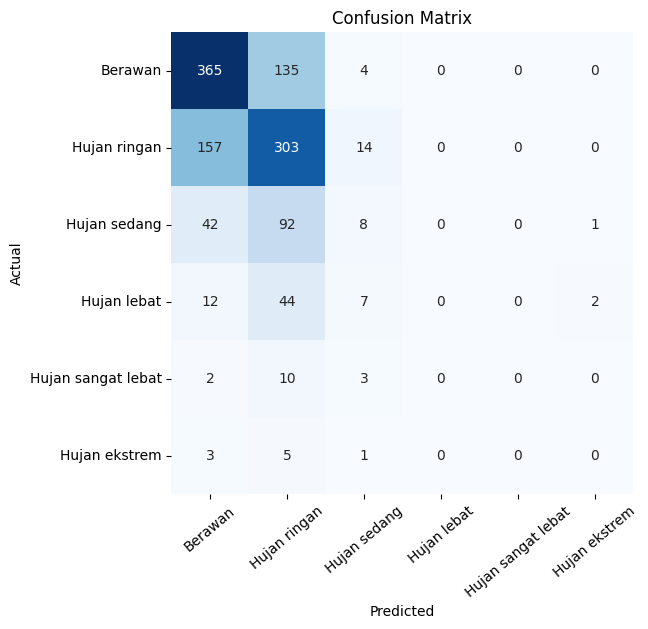

In [ ]:
# Define the desired column and row order
column_order = ['Berawan', 'Hujan ringan', 'Hujan sedang', 'Hujan lebat', 'Hujan sangat lebat', 'Hujan ekstrem']
row_order = ['Berawan', 'Hujan ringan', 'Hujan sedang', 'Hujan lebat', 'Hujan sangat lebat', 'Hujan ekstrem']

# Reorder the columns and rows in the confusion matrix DataFrame
cm_df = cm_df.reindex(columns=column_order, index=row_order)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap with reordered columns and rows
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, ax=ax)
plt.xticks(rotation=40)

# Set the axis labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Set the title
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(kelas_uji, kelas_prediksi) * 100

# Calculate precision
precision = precision_score(kelas_uji, kelas_prediksi, average='weighted') * 100

# Calculate recall
recall = recall_score(kelas_uji, kelas_prediksi, average='weighted') * 100

# Calculate F1-score
f1 = f1_score(kelas_uji, kelas_prediksi, average='weighted') * 100

# Print the metrics as percentages
print('Accuracy: {:.2f}%'.format(accuracy))
print('Precision: {:.2f}%'.format(precision))
print('Recall: {:.2f}%'.format(recall))
print('F1-score: {:.2f}%'.format(f1))


Accuracy: 55.87%
Precision: 48.87%
Recall: 55.87%
F1-score: 51.41%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report

# Calculate classification report
classification_rep = classification_report(kelas_uji, kelas_prediksi, target_names=labels, output_dict=True)

# Print the metrics per class
# Print the metrics per class
for class_label in labels:
    print(f'Class: {class_label}')
    print('-----------------------------')
    print(f'Precision: {classification_rep[class_label]["precision"] * 100:.2f}%')
    print(f'Recall: {classification_rep[class_label]["recall"] * 100:.2f}%')
    print(f'F1-score: {classification_rep[class_label]["f1-score"] * 100:.2f}%')
    print()

# Calculate and print the accuracy separately
accuracy = accuracy_score(kelas_uji, kelas_prediksi)
print('Accuracy:', accuracy)

# Calculate macro-averaged metrics
macro_precision = classification_rep['macro avg']['precision'] * 100
macro_recall = classification_rep['macro avg']['recall'] * 100
macro_f1 = classification_rep['macro avg']['f1-score'] * 100

# Calculate weighted-averaged metrics
weighted_precision = classification_rep['weighted avg']['precision'] * 100
weighted_recall = classification_rep['weighted avg']['recall'] * 100
weighted_f1 = classification_rep['weighted avg']['f1-score'] * 100

# Print the macro-averaged metrics
print('Macro-Averaged Metrics')
print('-----------------------------')
print(f'Macro Precision: {macro_precision:.2f}%')
print(f'Macro Recall: {macro_recall:.2f}%')
print(f'Macro F1-score: {macro_f1:.2f}%')
print()

# Print the weighted-averaged metrics
print('Weighted-Averaged Metrics')
print('-----------------------------')
print(f'Weighted Precision: {weighted_precision:.2f}%')
print(f'Weighted Recall: {weighted_recall:.2f}%')
print(f'Weighted F1-score: {weighted_f1:.2f}%')

Class: Berawan
-----------------------------
Precision: 62.82%
Recall: 72.42%
F1-score: 67.28%

Class: Hujan ekstrem
-----------------------------
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%

Class: Hujan lebat
-----------------------------
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%

Class: Hujan ringan
-----------------------------
Precision: 51.44%
Recall: 63.92%
F1-score: 57.01%

Class: Hujan sangat lebat
-----------------------------
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%

Class: Hujan sedang
-----------------------------
Precision: 21.62%
Recall: 5.59%
F1-score: 8.89%

Accuracy: 0.5586776859504132
Macro-Averaged Metrics
-----------------------------
Macro Precision: 22.65%
Macro Recall: 23.66%
Macro F1-score: 22.20%

Weighted-Averaged Metrics
-----------------------------
Weighted Precision: 48.87%
Weighted Recall: 55.87%
Weighted F1-score: 51.41%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Initialize a dictionary to store the accuracy per category
accuracy_per_category = {}

# Iterate over each category
for category in labels:
    # Get the indices of instances belonging to the current category
    indices = kelas_uji == category

    # Count the number of correct predictions for the current category
    correct_predictions = np.sum(kelas_uji[indices] == kelas_prediksi[indices])

    # Calculate the accuracy for the current category
    accuracy = correct_predictions / np.sum(indices)

    # Store the accuracy in the dictionary
    accuracy_per_category[category] = accuracy

# Print the accuracy per category
for category, accuracy in accuracy_per_category.items():
    print(f'Category: {category}')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print()

Category: Berawan
Accuracy: 72.42%

Category: Hujan ekstrem
Accuracy: 0.00%

Category: Hujan lebat
Accuracy: 0.00%

Category: Hujan ringan
Accuracy: 63.92%

Category: Hujan sangat lebat
Accuracy: 0.00%

Category: Hujan sedang
Accuracy: 5.59%

